# PBupsModelmusc with Algorithmic Differentiation in Julia
3 additional parameters were added to Bing’s accumulator model.  
To analyze the strong bias induced by unilateral FOF inactivation


In [1]:
# import packages..
import ForwardDiff
using ForwardDiff
# using PyPlot
import Base.convert
import Optim
using Optim

# === Upgrading from ForwardDiff v0.1 to v0.2
# instead of ForwardDiff.GradientNumber and ForwardDiff.HessianNumber, 
# we will use ForwardDiff.Dual

convert(::Type{Float64}, x::ForwardDiff.Dual) = Float64(x.value)
function convert(::Array{Float64}, x::Array{ForwardDiff.Dual}) 
    y = zeros(size(x)); 
    for i in 1:prod(size(x)) 
        y[i] = convert(Float64, x[i]) 
    end
    return y
end

immutable NumericPair{X,Y} <: Number
  x::X
  y::Y
end
Base.isless(a::NumericPair, b::NumericPair) = (a.x<b.x) || (a.x==b.x && a.y<b.y)


isless (generic function with 40 methods)

To evaluate how well a particular set of parameter values $\theta$ fits the behavioral data, we compute the probability of oberving the data given the model.

For each trial $i$, we will compute the likelihood of seeing the data under the model assuming that trials are independent. 

$P(D|\theta) = \prod_{i}P(d_i|t_{i,R},t_{i,L},\theta)$

$t_{i,R},t_{i,L}$ : the right and left click times on trial $i$

$d_i$ : the subject's decision on trial $i$

The best-fit parameter values are the parameters $\theta$ that maximize the likelihood (Maximum likelihood values)

To help maximize the likelihood(or log likelihood), we will compute the derivative $\partial P(d_i|t_{i,R},t_{i,L},\theta) / \partial\theta$ for each of the parameters in the set $\theta$.

After we get these gradients of 9 model parameters, we will apply them for optimization.

## Import data 

In [2]:
using MAT
ratdata = matread("chrono_fof_rawdata.mat")
# ratdata = matread("testdata.mat")
# ratdata = matread("chrono_B069_rawdata.mat")

Dict{ASCIIString,Any} with 2 entries:
  "rawdata"      => Dict{ASCIIString,Any}("is_probe"=>1x3836 Array{Any,2}:…
  "orig_rawdata" => Dict{ASCIIString,Any}("is_probe"=>1x3836 Array{Any,2}:…

In [3]:
function trialdata(rawdata, trial::Int)
    if rawdata["pokedR"][trial] > 0
        rat_choice = 1;  # "R"
    else
        rat_choice = -1; # "L"
    end;
    
    if typeof(rawdata["rightbups"][trial]) <: Array
        rvec = vec(rawdata["rightbups"][trial])::Array{Float64,1};
    else
        rvec = Float64[]
    end
    if typeof(rawdata["leftbups"][trial]) <: Array
        lvec = vec(rawdata["leftbups"][trial])::Array{Float64,1};
    else
        lvec = Float64[]
    end
    
    return rvec, lvec, 
    rawdata["T"][trial]::Float64, rat_choice
end



trialdata (generic function with 1 method)

In [4]:
@time RightClickTimes, LeftClickTimes, maxT, rat_choice = trialdata(ratdata["rawdata"], 1)

  0.085123 seconds (26.92 k allocations: 1.196 MB)


([0.0,0.012634999999999999],[0.0,0.028775000000000002,0.046955,0.07099,0.10994,0.12017,0.21356,0.21445,0.230355,0.26368,0.266795],0.2796896469572883,-1)

## bin_centers = make_bins(B, dx, binN)

In [5]:
"""
function bin_centers = make_bins(B, dx, binN)

Makes a series of points that will indicate bin centers. The first and
last points will indicate sticky bins. No "bin edges" are made-- the edge
between two bins is always implicity at the halfway point between their
corresponding centers. The center bin is always at x=0; bin spacing
(except for last and first bins) is always dx; and the position
of the first and last bins is chosen so that |B| lies exactly at the
midpoint between 1st (sticky) and 2nd (first real) bins, as well as
exactly at the midpoint between last but one (last real) and last
(sticky) bins.

Playing nice with ForwardDiff means that the *number* of bins must be predetermined.
So this function will not actually set the number of bins; what it'll do is determine their
locations. To accomplish this separation, the function uses as a third parameter binN,
which should be equal to the number of bins with bin centers > 0, as follows: 
   binN = ceil(B/dx)
and then the total number of bins will be 2*binN+1, with the center one always corresponding
to position zero. Use non-differentiable types for B and dx for this to work.
"""

function make_bins{T}(bins::Vector{T}, B, dx::T, binN)
    cnt = 1
    for i=-binN:binN
        bins[cnt] = i*dx
        cnt = cnt+1
    end
    
    if binN*dx == B
        bins[end] = B + dx
        bins[1] = -B - dx
    else
        bins[end] = 2*B - (binN-1)*dx
        bins[1] = -2*B + (binN-1)*dx
    end
end;

In [6]:
binN = ceil(4.1/0.25)
bins = zeros(typeof(binN), Int(binN*2+1))
@time make_bins(bins,4.1,0.25,binN)
bins

  0.065679 seconds (59.38 k allocations: 2.386 MB)


35-element Array{Float64,1}:
 -4.2 
 -4.0 
 -3.75
 -3.5 
 -3.25
 -3.0 
 -2.75
 -2.5 
 -2.25
 -2.0 
 -1.75
 -1.5 
 -1.25
  ⋮   
  1.5 
  1.75
  2.0 
  2.25
  2.5 
  2.75
  3.0 
  3.25
  3.5 
  3.75
  4.0 
  4.2 

In [7]:
B = 4.1
dx_test = 0.25
binN = ceil(B/dx_test)
bins = zeros(typeof(binN), Int(binN*2+1))
@profile make_bins(bins,B,dx_test,binN)
Profile.print()
Profile.clear_malloc_data() 
bin_centers = bins
bins

1 task.jl; anonymous; line: 447
 1 ...4/IJulia/src/IJulia.jl; eventloop; line: 138
  1 ...src/execute_request.jl; execute_request; line: 164
   1 loading.jl; include_string; line: 282
    1 ...ia/lib/julia/sys.dylib; typeinf_ext; (unknown line)
     1 ...a/lib/julia/sys.dylib; typeinf; (unknown line)
      1 ...a/lib/julia/sys.dylib; typeinf_uncached; (unknown line)
       1 ...a/lib/julia/sys.dylib; abstract_eval; (unknown line)
        1 .../lib/julia/sys.dylib; abstract_eval_call; (unknown line)
         1 .../lib/julia/sys.dylib; abstract_call; (unknown line)
          1 ...lib/julia/sys.dylib; abstract_call_gf; (unknown line)
           1 ...lib/julia/sys.dylib; typeinf; (unknown line)
            1 ...lib/julia/sys.dylib; typeinf; (unknown line)
             1 ...ib/julia/sys.dylib; typeinf_uncached; (unknown line)
              1 ...ib/julia/sys.dylib; abstract_eval; (unknown line)
               1 ...b/julia/sys.dylib; abstract_eval_call; (unknown line)
                1 ...b/j

35-element Array{Float64,1}:
 -4.2 
 -4.0 
 -3.75
 -3.5 
 -3.25
 -3.0 
 -2.75
 -2.5 
 -2.25
 -2.0 
 -1.75
 -1.5 
 -1.25
  ⋮   
  1.5 
  1.75
  2.0 
  2.25
  2.5 
  2.75
  3.0 
  3.25
  3.5 
  3.75
  4.0 
  4.2 

## Global Variables

In [8]:
# Global variables 
const epsilon = 10.0^(-10);
const dx = 0.25;
const dt = 0.02;
const total_rate = 40;

## Parameters

a : decision variable, memory accumulator

$$ da =
  \begin{cases}
    0       & \quad \text{if, } |a| \geq B \\
    \sigma_adW + (\delta_{t,t_R} \cdot \eta C(t) - \delta_{t,t_L} \cdot \eta C(t))dt + \lambda adt  & \quad \text{otherwise, }\\
  \end{cases}
$$



The impact of each click (C) is affected by sensory adaptation that depends on clicks from both right and left sides:

$$ 
\frac{\mathrm d C}{\mathrm d t} = \frac{1-C}{\tau_\phi} + (1-\phi)C(\delta_{t,t_R}+\delta_{t,t_L}) 
$$


sigma2_a ($\sigma_a^2$) : a diffusion constant, parameterizing noise in a.

sigma2_s ($\sigma_s^2$) : parameterizing noise when adding evidence from a right or left pulse. (incoming sensory evidence)

sigma2_i ($\sigma_i^2$) : initial condition for the dynamical equation at $t=0$

lam ($\lambda$) : consistent drift in the memory a ($\lambda<0$ : leaky or forgetful case, $\lambda>0$ : unstable or impulsive case)

B : decision bound

bias : bias parameter determines the position of the threshold in a (which a Rightward decision is made)

phi ($\phi$) : parameterize sensory adaptation (by defining the dynamics of C ($\phi>1$ : Facilitation, $\phi<1$ : Depression, $\phi=1$ : absense of sensory adaptation)

tau_phi ($\tau_\phi$) :

lapse : The lapse rate parameterizes the probability of making a random response.

______
biased_sigma2_s :  
biased_input :  
biased_lapse :   


In [9]:
sigma_a = 1; sigma_s = 0.1; sigma_i = 0.2; 
sigma_a_sbin = sigma_a  # remember we need this copy for Fmatrix
lam = -0.0005; B = 4.1; bias = 0.1; 
phi = 0.3; tau_phi = 0.1; lapse = 0.05*2;
biased_sigma2_s = 0.1; biased_input = 0.1; biased_lapse = 0.1;
params = [sigma_a, sigma_s, sigma_i, lam, B, bias, phi, tau_phi, lapse, biased_sigma2_s, biased_input, biased_lapse]   

sigma = params[1];
lam   = params[2];
c     = params[3];

## F = Fmatrix([sigma, lambda, c], bin_centers)

In [10]:
"""
function F = Fmatrix([sigma, lambda, c], bin_centers)

Uses globals
    dt
    dx
    epsilon       (=10.0^-10)

Returns a square Markov matrix of transition probabilities. 
Plays nice with ForwardDiff-- that is why bin_centers is a global vector (so that the rem
operations that go into defining the bins, which ForwardDiff doesn't know how to deal with,
stay outside of this differentiable function)

sigma  should be in (accumulator units) per (second^(1/2))
lambda should be in s^-1
c      should be in accumulator units per second
bin_centers should be a vector of the centers of all the bins. Edges will be at midpoints
       between the centers, and the first and last bin will be sticky.

dx is not used inside Fmatrix, because bin_centers specifies all we need to know.
dt *is* used inside Fmatrix, to convert sigma, lambda, and c into timestep units
"""
function Fmatrix{T}(F::AbstractArray{T,2},params::Vector, bin_centers)
    sigma2 = params[1];
    lam   = params[2];
    c     = params[3];
    
    sigma2_sbin = convert(Float64, sigma2)
      
    n_sbins = max(70, ceil(10*sqrt(sigma2_sbin)/dx))
    
    swidth = 5*sqrt(sigma2_sbin)
    sbinsize = swidth/n_sbins;#sbins[2] - sbins[1]
    base_sbins    = collect(-swidth:sbinsize:swidth)
    
    ps       = exp(-base_sbins.^2/(2*sigma2))
    ps       = ps/sum(ps);
    
    sbin_length = length(base_sbins)
    binN = length(bin_centers)

    mu = 0.
    for j in 2:binN
        if lam == 0
            mu = bin_centers[j]*exp(lam*dt)
        else
            mu = (bin_centers[j] + c/lam)*exp(lam*dt) - c/lam
        end
        
        for k in 1:sbin_length
            sbin = (k-1)*sbinsize + mu - swidth
             
            if sbin < bin_centers[1] #(bin_centers[1] + bin_centers[2])/2
                F[1,j] = F[1,j] + ps[k]
            elseif bin_centers[end] <= sbin#(bin_centers[end]+bin_centers[end-1])/2 <= sbins[k]
                F[end,j] = F[end,j] + ps[k]
            else # more condition
                if (sbin > bin_centers[1] && sbin < bin_centers[2])
                    lp = 1; hp = 2;
                elseif (sbin > bin_centers[end-1] && sbin < bin_centers[end])
                    lp = binN-1; hp = binN;
                else 
                    lp = floor(Int,((sbin-bin_centers[2])/dx) + 2)#find(bin_centers .<= sbins[k])[end]
                    hp = lp+1#Int(ceil((sbins[k]-bin_centers[2])/dx) + 1);
                end

                if lp < 1 
                    lp = 1; 
                end
                if hp < 1 
                    hp = 1;
                end

                if lp == hp
                    F[lp,j] = F[lp,j] + ps[k]
                else
                    dd = bin_centers[hp] - bin_centers[lp]
                    F[hp,j] = F[hp,j] + ps[k]*(sbin - bin_centers[lp])/dd
                    F[lp,j] = F[lp,j] + ps[k]*(bin_centers[hp] - sbin)/dd
                end                   
            end
        end
    end
    F[:,1] = 0; F[:,end] = 0; F[1,1] = 1; F[end,end] = 1;
end

Fmatrix (generic function with 1 method)

In [11]:
F = zeros(typeof(0.2),length(bin_centers),length(bin_centers))
@time Fmatrix(F,[0.2, 0., 0.0],bin_centers) # Fi
F

  0.346861 seconds (132.04 k allocations: 6.503 MB)


35x35 Array{Float64,2}:
 1.0  0.41182      0.218907     0.0917964    …  0.0          0.0          0.0
 0.0  0.197142     0.172131     0.112014        0.0          0.0          0.0
 0.0  0.187228     0.217923     0.187228        0.0          0.0          0.0
 0.0  0.119939     0.187228     0.217923        0.0          0.0          0.0
 0.0  0.0571377    0.119939     0.187228        0.0          0.0          0.0
 0.0  0.0202246    0.0571377    0.119939     …  0.0          0.0          0.0
 0.0  0.00531176   0.0202246    0.0571377       0.0          0.0          0.0
 0.0  0.00103206   0.00531176   0.0202246       0.0          0.0          0.0
 0.0  0.000148294  0.00103206   0.00531176      0.0          0.0          0.0
 0.0  1.59548e-5   0.000148294  0.00103206      0.0          0.0          0.0
 0.0  1.11105e-6   1.59548e-5   0.000148294  …  0.0          0.0          0.0
 0.0  0.0          1.11105e-6   1.59548e-5      0.0          0.0          0.0
 0.0  0.0          0.0          1.11105e

In [12]:
F = zeros(typeof(params[1]),length(bin_centers),length(bin_centers))
@time Fmatrix(F,params,bin_centers)
F

  0.000137 seconds (13 allocations: 7.547 KB)


35x35 Array{Float64,2}:
 1.0  0.461125    0.365007    0.274946    …  0.0         0.0         0.0
 0.0  0.0908452   0.0859592   0.0811359      0.0         0.0         0.0
 0.0  0.0945948   0.100835    0.0946575      0.0         0.0         0.0
 0.0  0.0888839   0.0945533   0.100892       0.0         0.0         0.0
 0.0  0.0737024   0.0889555   0.0945117      0.0         0.0         0.0
 0.0  0.0612142   0.0736883   0.0890271   …  0.0         0.0         0.0
 0.0  0.044833    0.0612781   0.0736743      0.0         0.0         0.0
 0.0  0.0329193   0.0448354   0.0613421      0.0         0.0         0.0
 0.0  0.0212918   0.0329616   0.0448377      0.0         0.0         0.0
 0.0  0.0138235   0.021298    0.0330038      0.0         0.0         0.0
 0.0  0.0078944   0.0138445   0.0213041   …  0.0         0.0         0.0
 0.0  0.00453257  0.0078985   0.0138655      0.0         0.0         0.0
 0.0  0.00228512  0.00454054  0.00790261     3.13941e-7  0.0         0.0
 ⋮                         

## logProbRight 
### (params::Vector, RightClickTimes::Vector, LeftClickTimes::Vector, Nsteps::Int)

* params = [sigma_a, sigma_s, sigma_i, lambda, B, bias, phi, tau_phi, lapse]
* RightClickTimes vector with elements indicating times of right clicks
* LeftClickTimes vector with elements indicating times of left clicks
* Nsteps number of timesteps to simulate 

a (column vector representing distribution of values of accumulator a)

a_trace (length(bin_centers)-by-Nsteps+1), a trace of the distribution of a as 
    a function of time
    
c_trace (row vector Nsteps+1 long, effective value of c as 
    a function of time after adaptation)


In [19]:
"""
version with inter-click interval(ici) for c_eff_net / c_eff_tot (followed the matlab code) 
(which was using dt for c_eff)

function logProbRight(params::Vector, RightClickTimes::Vector, LeftClickTimes::Vector, Nsteps::Int)

    Nsteps            number of timesteps to simulate
    RightClickTimes   vector with elements indicating times of right clicks
    LeftClickTimes    vector with elements indicating times of left clicks

    a      (column vector representing distribution of values of accumulator a)

    a_trace (length(bin_centers)-by-Nsteps+1), a trace of the distribution of a as 
            a function of time
    c_trace (row vector Nsteps+1 long, effective value of c as 
            a function of time after adaptation)

Takes params (including biased params)
    sigma_a = params[1]; sigma_s_R = params[2]; sigma_s_L = params[3];
    sigma_i = params[4]; lambda = params[5]; B = params[6]; bias = params[7]; 
    phi = params[8]; tau_phi = params[9]; lapse_R = params[10]; lapse_L = params[11];
    input_gain_weight = params[12];

Returns the log of the probability that the agent chose Right. 
"""

function logProbRight(params::Vector, RightClickTimes::Array{Float64,1}, LeftClickTimes::Array{Float64,1}, Nsteps::Int)
#     sigma_a = params[1]; sigma_s = params[2]; sigma_i = params[3]; 
#     lambda = params[4]; B = params[5]; bias = params[6]; 
#     phi = params[7]; tau_phi = params[8]; lapse = params[9]
#     biased_sigma2_s = params[10]; biased_input = params[11]; biased_lapse = params[12];
    sigma_a = params[1]; sigma_s_R = params[2]; sigma_s_L = params[3];
    sigma_i = params[4]; lambda = params[5]; B = params[6]; bias = params[7]; 
    phi = params[8]; tau_phi = params[9]; lapse_R = params[10]; lapse_L = params[11];
    input_gain_weight = params[12];

    if isempty(RightClickTimes) RightClickTimes = zeros(0) end;
    if isempty(LeftClickTimes ) LeftClickTimes  = zeros(0) end;
    
    NClicks = zeros(Int, Nsteps); 
    Lhere  = zeros(Int, length(LeftClickTimes)); 
    Rhere = zeros(Int, length(RightClickTimes)); 
    
    for i in 1:length(LeftClickTimes)
        Lhere[i] = ceil((LeftClickTimes[i]+epsilon)/dt)
    end
    for i in 1:length(RightClickTimes)
        Rhere[i] = ceil((RightClickTimes[i]+epsilon)/dt)
    end    
    
    for i in Lhere  
        NClicks[Int(i)] = NClicks[Int(i)]  + 1
    end
    for i in Rhere  
        NClicks[Int(i)] = NClicks[Int(i)]  + 1
    end
    
    # === Upgrading from ForwardDiff v0.1 to v0.2
    # instead of using convert we can use floor(Int, ForwardDiff.Dual) and
    # ceil(Int, ForwardDiff.Dual)

    binN = ceil(Int, B/dx)#Int(ceil(my_B/dx))  
    binBias = floor(Int, bias/dx) + binN+1  
    bin_centers = zeros(typeof(dx), binN*2+1)
    make_bins(bin_centers, B, dx, binN)  

    # Visualization
    a_trace = zeros(length(bin_centers), Nsteps)
    c_trace = zeros(1, Nsteps)
    
    ## biased lapse rate (lapse_R, lapse_L)
    a0 = zeros(typeof(sigma_a),length(bin_centers))
    a0[1] = lapse_L/2; 
    a0[end] = lapse_R/2;
    a0[binN+1] = 1-lapse_L/2-lapse_R/2; 
    
    temp_l = [NumericPair(LeftClickTimes[i],-1) for i=1:length(LeftClickTimes)]
    temp_r = [NumericPair(RightClickTimes[i],1) for i=1:length(RightClickTimes)]
    allbups = sort!([temp_l; temp_r])

    c_eff = 0.
    cnt = 0
        
    Fi = zeros(typeof(sigma_i),length(bin_centers),length(bin_centers))
    Fmatrix(Fi,[sigma_i, 0., 0.0], bin_centers)
    a = Fi*a0;
    
    a_trace[:,1] = a;
    
    F0 = zeros(typeof(sigma_a),length(bin_centers),length(bin_centers))
    Fmatrix(F0,[sigma_a*dt, lambda, 0.0], bin_centers)
    for i in 2:Nsteps
        net_input = 0.
        c_eff_tot = 0.
        c_eff_net = 0.
        net_i_input = 0.
        net_c_input = 0.
        
        if NClicks[i-1]==0
            c_eff_tot = 0.
            c_eff_net = 0.
            a = F0*a
        else
            for j in 1:NClicks[i-1]
                if cnt != 0 || j != 1
                    ici = allbups[cnt+j].x - allbups[cnt+j-1].x

                    c_eff = 1 + (c_eff*phi - 1)*exp(-ici/tau_phi)
                    c_eff_tot = c_eff_tot + c_eff
                    c_eff_net = c_eff_net + c_eff*allbups[cnt+j].y
                    
                    ## (input_gain_weight) 0 to 1 : 0-left, 1-right
                    net_c_input = (c_eff_tot+c_eff_net)/2 # right
                    net_i_input = c_eff_tot-net_c_input # left

                    net_input = 2*input_gain_weight*net_c_input - 2*(1-input_gain_weight)*net_i_input

                end
                if j == NClicks[i-1]
                    cnt = cnt+j
                end
            end
            
            ## biased params added
            net_sigma = sigma_a*dt + (sigma_s_L*net_i_input)/total_rate + (sigma_s_R*net_c_input)/total_rate
            F = zeros(typeof(net_sigma),length(bin_centers),length(bin_centers))
            Fmatrix(F,[net_sigma, lambda, net_input/dt], bin_centers)
            a = F*a
        end
        a_trace[:,i] = a
        c_trace[i] = c_eff*exp(lam*dt)
    end
        
    # likelihood of poking right
    pright = sum(a[binBias+2:end]) + 
    a[binBias]*((bin_centers[binBias+1] - bias)/dx/2) +
    a[binBias+1]*(0.5 + (bin_centers[binBias+1] - bias)/dx/2)

    a_trace[binBias,:]=a_trace[binBias,:]*((bin_centers[binBias+1] - bias)/dx/2)
    a_trace[binBias+1,:]=a_trace[binBias,:]*(0.5 + (bin_centers[binBias+1] - bias)/dx/2)
    
    # visualize
#     subplot(211)
#     plt = plot((0:(Nsteps-1))*dt,c_trace[:])  
#     print(maximum(a_trace,1))
#     plt = plot((0:(Nsteps-1))*dt,maximum(a_trace,1)[:]) 
    
#     subplot(212)
    
#     imshow(a_trace, interpolation="none", cmap=ColorMap("hot"),
#     extent=[0,(Nsteps-1)*dt,bin_centers[1],bin_centers[end]], aspect="auto")
#     xticks((0:(Nsteps-1))*dt)
#     yticks(bin_centers)

    
    return log(pright)
end

function logLike(params::Vector, RightClickTimes::Array{Float64,1}, LeftClickTimes::Array{Float64,1}, Nsteps::Int, rat_choice::Int)
    # likelihood of poking the same way the data did
    if rat_choice > 0
        # println("Right")
        return logProbRight(params, RightClickTimes, LeftClickTimes, Nsteps)
    elseif rat_choice < 0
        # println("Left")
        return log(1 - exp(logProbRight(params, RightClickTimes, LeftClickTimes, Nsteps)))
    end
end

logLike (generic function with 1 method)

## single_trial
### (params::Vector, RightClickTimes::Vector, LeftClickTimes::Vector, Nsteps::Int, rat_choice::Int)

In [20]:
""" 
function (LL, LLgrad) = 
    single_trial(params::Vector, RightClickTimes::Vector, LeftClickTimes::Vector, Nsteps::Int, rat_choice::Int)

Computes the log likelihood according to Bing's model, and returns log likelihood, gradient

params is a vector whose elements, in order, are
    sigma_a    square root of accumulator variance per unit time sqrt(click units^2 per second)
    sigma_s    standard deviation introduced with each click (will get scaled by click adaptation)
    sigma_i    square root of initial accumulator variance sqrt(click units^2)
    lambda     1/accumulator time constant (sec^-1). Positive means unstable, neg means stable
    B          sticky bound height (click units)
    bias       where the decision boundary lies (click units)
    phi        click adaptation/facilitation multiplication parameter
    tau_phi    time constant for recovery from click adaptation (sec)
    lapse      2*lapse fraction of trials are decided randomly

rat_choice     should be either "R" or "L"


RETURNS:


"""
# === Upgrading from ForwardDiff v0.1 to v0.2
# for Retrieving Lower-Order Results
#     # old way
#     answer, results = ForwardDiff.hessian(f, x, AllResults)
#     v = ForwardDiff.value(results)
#     g = ForwardDiff.gradient(results)
#     h = ForwardDiff.hessian(results) # == answer

#     # new way
#     out = HessianResult(x)
#     ForwardDiff.hessian!(out, f, x)
#     v = ForwardDiff.value(out)
#     g = ForwardDiff.gradient(out)
#     h = ForwardDiff.hessian(out)

function single_trial(params::Vector, RightClickTimes::Array{Float64,1}, LeftClickTimes::Array{Float64,1}, Nsteps::Int, rat_choice::Int)
    function llikey(params::Vector)
        logLike(params, RightClickTimes, LeftClickTimes, Nsteps, rat_choice)
    end

    result =  GradientResult(params)
    
    ForwardDiff.gradient!(result, llikey, params);
    
    LL     = ForwardDiff.value(result)
    LLgrad = ForwardDiff.gradient(result)
   
    return LL, LLgrad
end

# function single_trial(params::Vector, RightClickTimes::Vector, LeftClickTimes::Vector, Nsteps::Int, rat_choice::Int)
#     function llikey(params::Vector)
#         logLike(params, RightClickTimes, LeftClickTimes, Nsteps, rat_choice)
#     end

#     result =  HessianResult(params) 
#     ForwardDiff.hessian!(result, llikey, params);
    
#     LL     = ForwardDiff.value(result)
#     LLgrad = ForwardDiff.gradient(result)
#     LLhessian = ForwardDiff.hessian(result)
   
#     return LL, LLgrad, LLhessian
# end

single_trial (generic function with 1 method)

In [21]:
### =============== testing 1 ================= ####

# Parameters
sigma_a = 1; sigma_s_R = 0.1; sigma_s_L = 0.1; sigma_i = 0.2; 
lam = -0.0005; B = 10.; bias = .2; 
phi = 0.3; tau_phi = 0.1; lapse_R = 0.05*2; lapse_L = 0.1;
input_gain_weight = 0.1; 

params = [sigma_a, sigma_s_R, sigma_s_L, sigma_i, lam, B, bias, phi, tau_phi, lapse_R, lapse_L, input_gain_weight]   


RightClickTimes, LeftClickTimes, maxT, rat_choice = trialdata(ratdata["rawdata"], 30)
Nsteps = Int(cld(maxT,dt))

@time logLike(params, RightClickTimes, LeftClickTimes, Nsteps, rat_choice)
### =========================================== #### 

  0.200843 seconds (147.57 k allocations: 8.429 MB)


-0.05141143622520479

In [22]:
### =============== testing 2 ================= ####
@time LL, LLgrad = single_trial(params, RightClickTimes, LeftClickTimes, Nsteps, rat_choice)
println(LL)
println(LLgrad)
### =========================================== ####

  1.586499 seconds (1.29 M allocations: 69.047 MB, 1.51% gc time)
-0.05141143622520479
[-0.0003799253046747125,-5.1102713611881575e-5,-5.205623966290071e-5,-0.0011169283733993229,-7.665369417046369e-5,-0.0,0.0006896166489746672,0.0025594640989510635,-0.012065813304678569,-0.5263123348299219,6.563823148668583e-5,-0.0039144508563121305]


In [23]:
LL

-0.05141143622520479

In [24]:
LLgrad

12-element Array{Float64,1}:
 -0.000379925
 -5.11027e-5 
 -5.20562e-5 
 -0.00111693 
 -7.66537e-5 
 -0.0        
  0.000689617
  0.00255946 
 -0.0120658  
 -0.526312   
  6.56382e-5 
 -0.00391445 

# Maximize LL over parameter space
### Optimization with Optim.jl


In [25]:
function ComputeLL(params::Vector, ratdata, ntrials::Int)
    LL        = 0.
        
    for i in 1:ntrials
        RightClickTimes, LeftClickTimes, maxT, rat_choice = trialdata(ratdata, i)
        Nsteps = Int(ceil(maxT/dt))

        LLi = logLike(params, RightClickTimes, LeftClickTimes, Nsteps, rat_choice)
        LL        = LL + LLi;
    end
    
    LL = -LL
    return LL
end

ComputeLL (generic function with 1 method)

In [26]:
function ComputeGrad(params::Vector, ratdata, ntrials::Int)
    function WrapperLL(params::Vector)
        LL        = 0.

        for i in 1:ntrials
            RightClickTimes, LeftClickTimes, maxT, rat_choice = trialdata(ratdata, i)
            Nsteps = Int(ceil(maxT/dt))

            LLi = logLike(params, RightClickTimes, LeftClickTimes, Nsteps, rat_choice)
            LL        = LL + LLi;
        end

        LL = -LL
        return LL
    end

    result =  GradientResult(params)
    
    ForwardDiff.gradient!(result, WrapperLL, params);
    
    LL     = ForwardDiff.value(result)
    LLgrad = ForwardDiff.gradient(result)
   
    return LL, LLgrad
end

ComputeGrad (generic function with 1 method)

In [27]:
@profile ComputeLL(params,ratdata["rawdata"],300)
Profile.print()
Profile.clear_malloc_data() 

8    ...a/lib/julia/sys.dylib; trunc; (unknown line)
1224 task.jl; anonymous; line: 447
 1224 .../IJulia/src/IJulia.jl; eventloop; line: 138
  1224 ...rc/execute_request.jl; execute_request; line: 164
   1224 loading.jl; include_string; line: 282
    1    .../lib/julia/sys.dylib; typeinf_ext; (unknown line)
     1 ...a/lib/julia/sys.dylib; typeinf; (unknown line)
      1 ...a/lib/julia/sys.dylib; typeinf_uncached; (unknown line)
       1 ...a/lib/julia/sys.dylib; abstract_eval; (unknown line)
        1 .../lib/julia/sys.dylib; abstract_eval_call; (unknown line)
         1 .../lib/julia/sys.dylib; abstract_call; (unknown line)
          1 ...lib/julia/sys.dylib; abstract_call_gf; (unknown line)
           1 ...lib/julia/sys.dylib; typeinf; (unknown line)
            1 ...lib/julia/sys.dylib; typeinf; (unknown line)
             1 ...ib/julia/sys.dylib; typeinf_uncached; (unknown line)
              1 ...ib/julia/sys.dylib; abstract_eval; (unknown line)
               1 ...b/julia/sys.dy

In [28]:
ComputeLL(params,ratdata["rawdata"],300)

187.27965794820634

In [29]:
@time ComputeGrad(params,ratdata["rawdata"],300)

  8.339663 seconds (1.07 M allocations: 3.213 GB, 5.21% gc time)


(187.27965794820628,[-5.549597301851585,-1.130813647916398,-0.23575674500351487,-9.955629855457186,-0.89095234965332,-0.0,9.699477615778916,20.888094057629836,-157.69392743568037,-240.2996554618079,-6.789953425498453,-34.57995362748183])

In [30]:
function ComputeHess(params::Vector, ratdata, ntrials::Int)
    function WrapperLL(params::Vector)
        LL        = 0.

        for i in 1:ntrials
            RightClickTimes, LeftClickTimes, maxT, rat_choice = trialdata(ratdata["rawdata"], i)
            Nsteps = Int(ceil(maxT/dt))

            LLi = logLike(params, RightClickTimes, LeftClickTimes, Nsteps, rat_choice)
            LL        = LL + LLi;
        end

        LL = -LL
        return LL
    end

    result =  HessianResult(params)
    
    ForwardDiff.hessian!(result, WrapperLL, params);
    
    LL     = ForwardDiff.value(result)
    LLgrad = ForwardDiff.gradient(result)
    LLHess = ForwardDiff.hessian(result)
   
    return LL, LLgrad, LLHess
end

ComputeHess (generic function with 1 method)

In [31]:
@time ComputeHess(params,ratdata,300)

565.924713 seconds (5.89 M allocations: 44.562 GB, 1.35% gc time)


(187.27965794820628,[-5.549597301851585,-1.130813647916398,-0.23575674500351487,-9.955629855457186,-0.89095234965332,-0.0,9.699477615778916,20.888094057629836,-157.69392743568037,-240.2996554618079,-6.789953425498453,-34.57995362748183],
12x12 Array{Float64,2}:
  3.83142    0.803943    0.11019       8.02964  …     5.79368      -0.916431
  0.803943   0.174673    0.0229292     1.69184        1.44828      -1.49186 
  0.11019    0.0229292   0.00333073    0.25789        0.0289449     0.894884
  8.02964    1.69184     0.25789      14.0943         7.2905       22.3806  
  0.841607   0.188535    0.0300791    -3.75335       -0.72305      13.7483  
 -0.0       -0.0        -0.0          -0.0      …    -0.0          -0.0     
 -2.90203   -0.387241   -0.189147    -10.0402        45.7989     -342.349   
 -2.91655   -1.97941    -0.160734     -6.06706      -24.5047      -10.2452  
 28.0308    15.8175      1.4844       70.4741       225.646      -311.11    
 26.1572     4.50523     1.78274      70.0849

In [32]:
function Likely_all_trials{T}(LL::AbstractArray{T,1},params::Vector, ratdata, ntrials::Int)     
    for i in 1:ntrials
        RightClickTimes, LeftClickTimes, maxT, rat_choice = trialdata(ratdata, i)
        Nsteps = Int(ceil(maxT/dt))

        LL[i] = logLike(params, RightClickTimes, LeftClickTimes, Nsteps, rat_choice)
    end
end

Likely_all_trials (generic function with 1 method)

In [34]:
ntrials = 27;
likely_all = zeros(ntrials)
@time Likely_all_trials(likely_all, params, ratdata["rawdata"], ntrials)
likely_all

  0.179810 seconds (18.18 k allocations: 18.753 MB, 7.36% gc time)


27-element Array{Float64,1}:
 -0.0512933
 -0.060176 
 -0.35093  
 -0.331159 
 -2.04296  
 -0.062689 
 -0.495033 
 -0.051707 
 -0.618616 
 -0.45022  
 -0.0513322
 -0.571378 
 -0.051325 
  ⋮        
 -2.99573  
 -0.0512933
 -0.0513017
 -0.0512933
 -0.0513435
 -0.492525 
 -1.59802  
 -0.0514251
 -0.0513397
 -0.0611144
 -0.0512933
 -0.0512933

In [36]:
# Parameters
sigma_a = 1; sigma_s_R = 0.1; sigma_s_L = 0.1; sigma_i = 0.2; 
lam = -0.0005; B = 10.; bias = .2; 
phi = 0.3; tau_phi = 0.1; lapse_R = 0.05*2; lapse_L = 0.1;
input_gain_weight = 0.1; 

params = [sigma_a, sigma_s_R, sigma_s_L, sigma_i, lam, B, bias, phi, tau_phi, lapse_R, lapse_L, input_gain_weight]   


ntrials = 10#3836

function LL_f(params::Vector)
    return ComputeLL(params, ratdata["rawdata"], ntrials)
end

function LL_g!(params::Vector, grads::Vector)
#     LL, LLgrad, LLhess = llikey(params)
    LL, LLgrad = ComputeGrad(params, ratdata["rawdata"], ntrials)
    for i=1:length(params)
        grads[i] = LLgrad[i]
    end
end

function LL_fg!(params::Vector, grads)
    LL, LLgrad = ComputeGrad(params, ratdata["rawdata"], ntrials)
    for i=1:length(params)
        grads[i] = LLgrad[i]
    end
    return LL
end

d4 = DifferentiableFunction(LL_f,
                            LL_g!,
                            LL_fg!)

Optim.DifferentiableFunction(LL_f,LL_g!,LL_fg!)

In [37]:
# Parameters
sigma_a = 1; sigma_s_R = 0.1; sigma_s_L = 0.1; sigma_i = 0.2; 
lam = -0.0005; B = 10.; bias = .2; 
phi = 0.3; tau_phi = 0.1; lapse_R = 0.05*2; lapse_L = 0.1;
input_gain_weight = 0.1; 

params = [sigma_a, sigma_s_R, sigma_s_L, sigma_i, lam, B, bias, phi, tau_phi, lapse_R, lapse_L, input_gain_weight]   
params = [2.63352, 0.287501, 0.201707, 0.501707, -0.21113, 6.23087, 1.487071, 0.537924, 0.69, 0.140861, 
    0.22412, 0.99205]


l = [0, 0, 0,        0, -5, 5,  -5, 0.01, 0.005, 0., 0., 0.]
u = [200, 200, 200, 30, +5, 25, +5, 1.2,    0.7, 1., 1., 1.]

res = optimize(d4, params, l, u, Fminbox(); 
         optimizer = GradientDescent, optimizer_o = OptimizationOptions(g_tol = 1e-12,
                                                                        x_tol = 1e-10,
                                                                        f_tol = 1e-6,                                                                        
                                                                        iterations = 200,
                                                                        store_trace = true,
                                                                        show_trace = true,
                                                                        extended_trace = true))


Iter     Function value   Gradient norm 
 

    0     4.134220e+00     4.816448e+00
 * g(x): [0.03985425247264205,-0.002881165826043352,0.0027449704534518705,0.7297994817052555,0.4564227165192451,-6.924906818199555e-5,-2.486637607372114,4.055477638620321,-3.3211646428752677,4.81644756781592,-4.660953095316625,2.9852733374660696]
 * x: [2.63352,0.287501,0.201707,0.501707,-0.21113,6.23087,1.487071,0.537924,0.69,0.140861,0.22412,0.99205]
     1     3.703122e+00     3.648177e+01
 * g(x): [0.033718766742466745,-0.003029009180596024,0.0025594602628260486,0.7188493254379523,0.46754627049642516,-6.924904407767482e-5,-2.0423557748889505,3.8545016453968555,36.48176542518356,4.773418702906722,-3.9559764006259903,2.888612422172278]
 * x: [2.6332905684281704,0.28751756812887214,0.20169123299204536,0.4975071829449284,-0.21375753367693023,6.230870398631763,1.5013860401959194,0.5145897535531948,0.6999977017550162,0.1132637608739561,0.25089967480585473,0.9850163742202372]
     2     2.326962e+00     3.607225e+01
 * g(x): [0.03659632355415896,-0.

Results of Optimization Algorithm
 * Algorithm: Fminbox with Gradient Descent
 * Starting Point: [2.63352,0.287501, ...]
 * Minimizer: [1.7309972441566877,1.1109757580212767, ...]
 * Minimum: 3.159342e-09
 * Iterations: 6
 * Convergence: true
   * |x - x'| < 1.0e-10: true
   * |f(x) - f(x')| / |f(x)| < 1.0e-06: true
   * |g(x)| < 1.0e-12: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 1924
 * Gradient Calls: 1924

In [39]:
x_bf = res.f_minimum

3.159342011326867e-9

In [40]:
res

Results of Optimization Algorithm
 * Algorithm: Fminbox with Gradient Descent
 * Starting Point: [2.63352,0.287501, ...]
 * Minimizer: [1.7309972441566877,1.1109757580212767, ...]
 * Minimum: 3.159342e-09
 * Iterations: 6
 * Convergence: true
   * |x - x'| < 1.0e-10: true
   * |f(x) - f(x')| / |f(x)| < 1.0e-06: true
   * |g(x)| < 1.0e-12: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 1924
 * Gradient Calls: 1924

In [41]:
res.minimum

12-element Array{Float64,1}:
  1.731      
  1.11098    
  1.13063    
  0.519989   
 -2.34754    
  6.60855    
  4.36703    
  0.379205   
  0.524588   
  2.69336e-20
  0.539024   
  8.66897e-7 

In [42]:
@time LL, LLgrad, LLhess = ComputeHess(params,ratdata,ntrials)

  7.174227 seconds (39.54 k allocations: 473.843 MB, 0.90% gc time)


(4.135263262185902,[0.039888427841268725,-0.002564341332247695,0.003196747460482433,0.7299782059956013,0.4564242599912156,0.0,-2.486649512318266,4.055512649390089,-3.3301533444125133,4.816988972641633,-4.660663655149032,2.9738912399887107],
12x12 Array{Float64,2}:
 -0.0210064    -0.000867046  -0.000339753  …    0.323183     0.254954   
 -0.000867046  -4.44016e-5   -7.295e-6          0.0260977    0.0166804  
 -0.000339753  -7.295e-6     -1.16934e-5       -0.00220189   0.000945184
 -0.0951046    -0.00401407   -0.00154261       -0.223875     0.150289   
  0.0259483     0.00208165   -8.63717e-5       -0.723677    -0.248656   
 -0.0          -0.0           0.0          …   -0.0          0.0        
 -0.0294399    -0.000364481  -0.00111968        2.59941     -0.94157    
  0.453426      0.0258502     0.00342436      -10.178       -1.61279    
 -0.312758     -0.0193376    -0.0039597         7.65498      0.221139   
  0.0389599     0.00314609   -0.000265439      -0.89228     -0.732687   
  0.3

In [48]:
function main()
    
    ratname = "fof"
    # data import
    ratdata = matread(*("chrono_",ratname,"_rawdata.mat"))
    println("rawdata of ", ratname, " imported" )

    # number of trials
    ntrials = 2#length(ratdata["rawdata"]["rightbups"]) 

    # Parameters
    sigma_a = 1; sigma_s_R = 0.1; sigma_s_L = 0.1; sigma_i = 0.2; 
    lam = -0.0005; B = 10.; bias = .2; 
    phi = 0.3; tau_phi = 0.1; lapse_R = 0.05*2; lapse_L = 0.1;
    input_gain_weight = 0.1; 

    params = [sigma_a, sigma_s_R, sigma_s_L, sigma_i, lam, B, bias, phi, tau_phi, lapse_R, lapse_L, input_gain_weight]   

    l = [0, 0, 0,        0, -5, 5,  -5, 0.01, 0.005, 0., 0., 0.]
    u = [200, 200, 200, 30, +5, 25, +5, 1.2,    0.7, 1., 1., 1.]


    function LL_f(params::Vector)
        return ComputeLL(params, ratdata["rawdata"], ntrials)
    end

    function LL_g!(params::Vector, grads::Vector)
    #     LL, LLgrad, LLhess = llikey(params)
        LL, LLgrad = ComputeGrad(params, ratdata["rawdata"], ntrials)
        for i=1:length(params)
            grads[i] = LLgrad[i]
        end
    end

    function LL_fg!(params::Vector, grads)
        LL, LLgrad = ComputeGrad(params, ratdata["rawdata"], ntrials)
        for i=1:length(params)
            grads[i] = LLgrad[i]
        end
        return LL
    end
    
    d4 = DifferentiableFunction(LL_f,
                                LL_g!,
                                LL_fg!)

    tic()
    history = optimize(d4, params, l, u, Fminbox(); 
             optimizer = GradientDescent, optimizer_o = OptimizationOptions(g_tol = 1e-12,
                                                                            x_tol = 1e-10,
                                                                            f_tol = 1e-6,
                                                                            iterations = 200,
                                                                            store_trace = true,
                                                                            ))
    fit_time = toc()
    println(history.minimum)
    println(history)

    ## do a single functional evaluation at best fit parameters and save likely for each trial
    likely_all = zeros(typeof(sigma_i),ntrials)
    x_bf = history.minimum
    Likely_all_trials(likely_all, x_bf, ratdata["rawdata"], ntrials)
    LL, LLgrad, LLhess = ComputeHess(x_bf, ratdata, ntrials)

#     matwrite(saveto_filename, Dict([("ratname",ratname),
#                                     ("x_init",params),
#                                     ("trials",ntrials),
#                                     #("history",history),
#                                     ("f",history.f_minimum), 
#                                     ("x_converged",history.x_converged),
#                                     ("f_converged",history.f_converged),
#                                     ("g_converged",history.g_converged),                                    
#                                     ("fit_time",fit_time),
#                                     ("x_bf",history.minimum),
#                                     ("myfval", history.f_minimum),
#                                     ("hessian", LLhess),
#                                     ("likely",likely_all)
#                                     ]))

    
end

main (generic function with 1 method)

In [49]:
main()

rawdata of fof imported
elapsed time: 35.453231282 seconds
[1.040297858743158,0.3855183595937913,0.3802655310819716,0.2934223334281832,-0.002873605131347862,10.00816520524985,0.2679934928557286,0.4373346973338629,0.005000000000000001,1.1043846725634423e-33,0.3294399575162286,0.2205311790547882]
Results of Optimization Algorithm
 * Algorithm: Fminbox with Gradient Descent
 * Starting Point: [1.0,0.1, ...]
 * Minimizer: [1.040297858743158,0.3855183595937913, ...]
 * Minimum: 4.008682e-12
 * Iterations: 9
 * Convergence: true
   * |x - x'| < 1.0e-10: true
   * |f(x) - f(x')| / |f(x)| < 1.0e-06: true
   * |g(x)| < 1.0e-12: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 1463
 * Gradient Calls: 1463


(4.008682275022088e-12,[2.8171793764002046e-11,3.394686295982578e-42,1.721957041604369e-11,1.357727714381168e-10,1.853747079078714e-12,0.0,-1.6230642918965976e-11,-4.110850225410007e-12,2.4191248172167967e-9,0.9999999999996056,-2.3996039206800156e-12,2.6090755900490433e-10],
12x12 Array{Float64,2}:
  1.71706e-10   1.52746e-40   1.04978e-10  …  -1.68637e-11   1.71531e-9 
  1.52746e-40   1.14511e-41   1.07629e-40     -2.03206e-42   1.07825e-39
  1.04978e-10   1.07629e-40   6.39707e-11     -1.03077e-11   1.05173e-9 
  9.26231e-10   1.28158e-40   5.66333e-10     -8.12738e-11   8.71207e-9 
  1.11282e-11   2.0639e-41    7.62248e-12     -1.10966e-12   8.08241e-11
  0.0           0.0           0.0          …  -0.0           0.0        
 -1.12643e-10  -1.45164e-41  -6.88609e-11      9.71569e-12  -1.04996e-9 
 -2.71213e-11  -1.04092e-40  -1.62879e-11      2.46076e-12  -1.66441e-10
  1.59705e-8    7.82846e-39   9.58542e-9      -1.44809e-9    9.81272e-8 
 -2.7775e-12    1.69734e-42  -1.69753e-12  

In [ ]:
# make grid of params. get likelihood with laplace approximation -> likelihood landscape

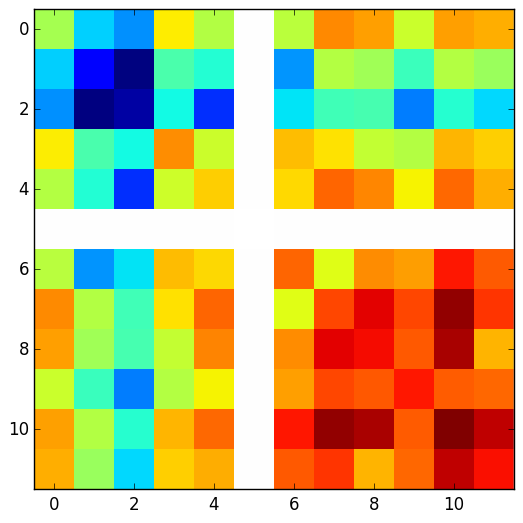

3.159342011326867e-9[3.159342011326867e-9]

In [52]:
## with hessian matrix
using PyPlot
imshow(log(abs(LLhess)), interpolation="none")

history = res
print(history.f_minimum)
X = history.minimum
tt = history.f_minimum * exp((-1/2)*transpose(X-history.minimum)*LLhess*(X-history.minimum))
print(tt)


## Simulation 
### generate synthetic data, test the model with several parameter sets
1. Generate Click trials
2. Run Virtual rats
3. Fit the synthetic data
4. compare the best-fit parameters with the parameters that we used to generate the data

In [53]:
# function to make clicks.

function make_clicks_trains(difficulty, T, ntrials)

    # difficulty : 0.025 (39:1) / 0.075 (37:3) / 0.225 (31:9) / 0.35 (26:14)
    # T - max time (sec) : 0.5
    # ntrials : 1000

    R = 40

    # difficulty = r1:r2
    r1 = R*(1.0-difficulty);
    r2 = R-r1;

    # data = Array(Dict,ntrials)
    Ls = Array(Any,1,ntrials)
    Rs = Array(Any,1,ntrials)
    As = Array(Any,ntrials)
    Gams = Array(Any,ntrials)

    for t=1:ntrials

    if rand()<0.5
        gamma = log(r1/r2) # log of click rate ratio
    else
        gamma = -log(r1/r2)
    end
#     T = 0.5

    rrate = R/(exp(-gamma)+1)
    lrate = R - rrate

    srate = R*1000
    bup_width = 3
    lT2 = ceil(Int, T * 1000 / bup_width)
    tp1 = find(rand(lT2) .< lrate/(1000/bup_width))
    tp2 = find(rand(lT2) .< rrate/(1000/bup_width))

    prepend!(tp1,[0])
    prepend!(tp2,[0])

    leftbups = tp1 * (srate / (1000 / bup_width))/srate
    rightbups = tp2 * (srate / (1000 / bup_width))/srate

    answer = gamma > 0?1:-1

    Ls[t] = leftbups
    Rs[t] = rightbups
    As[t] = answer
    Gams[t] = gamma

    end

    data = Dict([("leftbups",Ls),
        ("gammas",Gams),
        ("rightbups",Rs),
        ("answer",As)])
    return data
end

make_clicks_trains (generic function with 1 method)

In [54]:
@time data = make_clicks_trains(0.075,0.8,10000)

  0.934260 seconds (773.78 k allocations: 171.946 MB, 6.48% gc time)


Dict{ASCIIString,Array{Any,N}} with 4 entries:
  "gammas"    => Any[-2.512305623976115,-2.512305623976115,-2.512305623976115,2…
  "rightbups" => 1x10000 Array{Any,2}:…
  "leftbups"  => 1x10000 Array{Any,2}:…
  "answer"    => Any[-1,-1,-1,1,-1,1,1,-1,-1,1  …  -1,-1,1,1,1,-1,-1,1,-1,1]

In [55]:
function clicks_from_data(data, ntrials)
    
    data_len = length(data["rightbups"]) 
    
    Ls = Array(Any,1,ntrials)
    Rs = Array(Any,1,ntrials)
    As = Array(Any,ntrials)
    Gams = Array(Any,ntrials)

    for t=1:ntrials
        i = mod(t, data_len)
        if i==0
            i = data_len;
        end
        Ls[t] = data["leftbups"][i]
        Rs[t] = data["rightbups"][i]
        As[t] = (data["hit"][i] == true) == (data["pokedR"][i] == true) ? 1 : -1
        Gams[t] = data["gamma"][i]
    end

    data = Dict([("leftbups",Ls),
        ("gamma",Gams),
        ("rightbups",Rs),
        ("answer",As)])
    return data
end

clicks_from_data (generic function with 1 method)

In [65]:
data = clicks_from_data(ratdata["rawdata"], 1000)

Dict{ASCIIString,Array{Any,N}} with 4 entries:
  "rightbups" => 1x1000 Array{Any,2}:…
  "leftbups"  => 1x1000 Array{Any,2}:…
  "gamma"     => Any[-3.5,-2.5,0.5,2.5,3.5,-1.5,1.5,-1.5,2.5,-2.5  …  -1.0,2.0,…
  "answer"    => Any[-1,-1,1,1,1,-1,1,-1,1,-1  …  -1,1,-1,1,-1,-1,-1,1,-1,-1]

In [57]:
# run simulation : get virtual rat choice

# rats with different bias params.
# 1. strong post categorization (biased_lapse)
# 2. strong biased gain input (biased_input) 1~0 : >0.5 right bias, <0.5 left bias
# 3. accumulation shift (bias)
# 4. biased sensory noise (biased_noise)

# virtual rat
# # sigma_a / sigma_s_R / sigma_s_L / sigma_i / lambda / B / bias / phi / tau_phi / 
# # lapse_R / lapse_L / input_gain_weight

# params =[1.3  0.  0.   0. 0.06 10 0    0.33 0.39 0.03 0.5  0.5; # Strong Post Categorization
#          1.3  0.  0.   0. 0.06 10 0    0.33 0.39 0.03 0.03 0.1; # Strong biased gain input
#          1.3  0.  200. 0. 0.06 10 0    0.33 0.39 0.03 0.03 0.5; # Biased Sensory Noise
#          1.3  0.  0.   0. 0.06 10 -6.5 0.33 0.39 0.03 0.03 0.5; # Accumulation shift (bias)
#         ];

function run_virtual_rat(data, param, T)

    ntrials = length(data["leftbups"])
    Rs = Array(Any,1,ntrials)
    Ts = Array(Any,1,ntrials)
    Delta = Array(Int,1,ntrials)

    sigma_a = sqrt(param[1]); sigma_s_R = sqrt(param[2]); sigma_s_L = sqrt(param[3]);
    sigma_i = param[4]; lambda = param[5]; B = param[6]; bias = param[7]; 
    phi = param[8]; tau_phi = param[9]; lapse_R = param[10]; lapse_L = param[11];
    input_gain_weight = param[12];
    
    Flip = rand(ntrials) 
    Flip_RtoL = Flip .< lapse_L
    Flip_LtoR = Flip .> 1-lapse_R
    
    for i=1:ntrials
        leftbups = data["leftbups"][i]
        rightbups = data["rightbups"][i]
#         answer = data["answer"][i]

        rat_choice = 0;

        dt = 0.0001

        time = dt:dt:T
        lC = zeros(time)
        rC = zeros(time)
        dC = zeros(time)

        adap_c = zeros(time)
        adap_c[1] = 1.

        dd = exp(dt*lambda)
        eta = sigma_a*sqrt(dt)

#             figure()
        for t = 1:length(time)-1

            if isempty(find(time[t] .< leftbups .<= time[t+1])) & isempty(find(time[t] .< rightbups .<= time[t+1]))
                adap_c[t+1] = adap_c[t] + ((1-adap_c[t])/tau_phi + (phi-1)*adap_c[t])*dt
            else
                adap_c[t+1] = adap_c[t] + (1-adap_c[t])/tau_phi*dt
            end

            # sigma_i ?
#             if t==1
#                 lC[1] = sigma_i
#                 rc[1] = sigma_i
#             end
            
            if ~isempty(find(time[t] .< leftbups .<= time[t+1]))
                lC[t+1] = lC[t] + adap_c[t+1] + (randn()*sigma_s_L)
            else
                lC[t+1] = lC[t]*dd + randn()*eta

            end

            if ~isempty(find(time[t] .< rightbups .<= time[t+1]))
                rC[t+1] = rC[t] + adap_c[t+1] + (randn()*sigma_s_R)
            else
                rC[t+1] = rC[t]*dd + randn()*eta
            end

            lC[t+1] = max(0,lC[t+1])
            rC[t+1] = max(0,rC[t+1])
            
            dC[t+1] = (2*input_gain_weight*rC[t+1] - 2*(1-input_gain_weight)*lC[t+1]) + bias #rC[t+1] - lC[t+1]

            if dC[t+1] >= B
                dC[t+1:end] = dC[t+1]
                rat_choice = 1;
                break;
            elseif dC[t+1] <= -B
                dC[t+1:end] = dC[t+1]
                rat_choice = 0;
                break;
            end
        end

#             plot(time,dC,color="black")
#             plot(reshape(leftbups,(1,size(leftbups,1))),-B+0.25,color="blue",linestyle="none",marker="^",markeredgecolor="none")
#             plot(reshape(rightbups,(1,size(rightbups,1))),B-0.25,color="red",linestyle="none",marker="v",markeredgecolor="none")

#             new_position = [0.06,0.06,0.91,0.27] # Position Method 2
#             ax = gca()
#             ax[:set_position](new_position)
#             yticks(-B:1:B)
#             grid()

        if rat_choice == 0
            rat_choice = dC[end] > 0?1:0
        end

        if Flip_RtoL[i]
            rat_choice = rat_choice == 1?0:0
        elseif Flip_LtoR[i]
            rat_choice = rat_choice == 0?1:1
        end
        
        Rs[i] = rat_choice
        if size(leftbups,1) > 1 || size(rightbups,1) > 1
            Ts[i] = maximum([leftbups; rightbups]) + 0.1
        else
            Ts[i] = maximum([leftbups rightbups]) + 0.1
        end
        Delta[i] = length(rightbups) - length(leftbups);

    end
    results =  Dict([("leftbups", data["leftbups"]),
        ("rightbups", data["rightbups"]),
#         ("answer", data["answer"]),
        ("pokedR", Rs),
        ("params", param),
        ("Delta", Delta),
        ("T",Ts)
        ])
    return results
end



run_virtual_rat (generic function with 1 method)

In [64]:
# sigma_a / sigma_s_R / sigma_s_L / sigma_i / lambda / B / bias / phi / tau_phi / 
# lapse_R / lapse_L / input_gain_weight

params =[1.3  0.  0.   0. 0.06 10 0    0.33 0.39 0.03 0.5  0.5; # Strong Post Categorization
         1.3  0.  0.   0. 0.06 10 0    0.33 0.39 0.03 0.03 0.1; # Strong biased gain input
         1.3  0.  200. 0. 0.06 10 0    0.33 0.39 0.03 0.03 0.5; # Biased Sensory Noise
         1.3  0.  0.   0. 0.06 10 -6.5 0.33 0.39 0.03 0.03 0.5; # Accumulation shift (bias)
        ];
ntrials = 10000



10000

In [66]:
## run virtual rat with 4 different parameter set.
tic()
results1 = run_virtual_rat(data,params[1,:],0.5)
C1 = sort(unique(results1["Delta"]))
prob_right1 = zeros(length(C1))
for i=1:length(C1)
    ci = C1[i]
    idd = find(ci.==results1["Delta"])
    prob_right1[i] = sum(results1["pokedR"][idd])/length(idd)
end
println("set1 done")
println(toc())

results2 = run_virtual_rat(data,params[2,:],0.5)
C2 = sort(unique(results2["Delta"]))
prob_right2 = zeros(length(C2))
for i=1:length(C2)
    ci = C2[i]
    idd = find(ci.==results2["Delta"])
    prob_right2[i] = sum(results2["pokedR"][idd])/length(idd)
end
println("set2 done")

results3 = run_virtual_rat(data,params[3,:],0.5)
C3 = sort(unique(results3["Delta"]))
prob_right3 = zeros(length(C3))
for i=1:length(C3)
    ci = C3[i]
    idd = find(ci.==results3["Delta"])
    prob_right3[i] = sum(results3["pokedR"][idd])/length(idd)
end
println("set3 done")

results4 = run_virtual_rat(data,params[4,:],0.5)
C4 = sort(unique(results4["Delta"]))
prob_right4 = zeros(length(C4))
for i=1:length(C4)
    ci = C4[i]
    idd = find(ci.==results4["Delta"])
    prob_right4[i] = sum(results4["pokedR"][idd])/length(idd)
end
println("set4 done")



set1 done
elapsed time: 206.095529131 seconds
206.095529131
set2 done
set3 done
set4 done


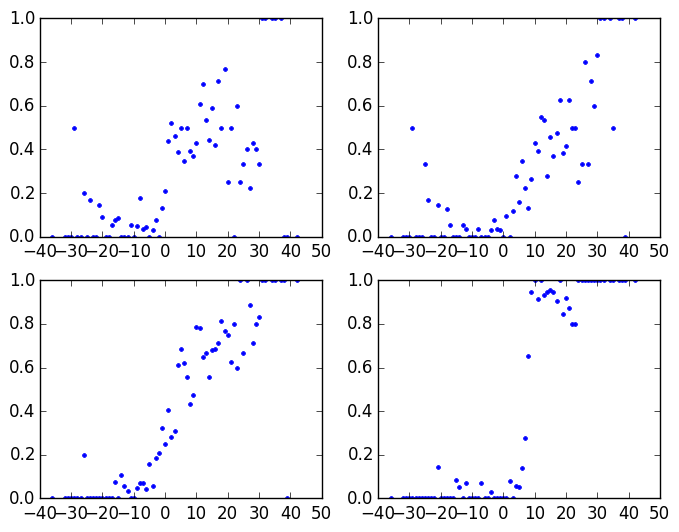

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x322a57810>

In [67]:
figure; 
subplot(221); plot(C1,prob_right1,linestyle="none",marker=".")
subplot(222); plot(C2,prob_right2,linestyle="none",marker=".")
subplot(223); plot(C3,prob_right3,linestyle="none",marker=".")
subplot(224); plot(C4,prob_right4,linestyle="none",marker=".")



In [68]:
using LsqFit

In [69]:
sig4(x, p) = p[1] + p[2]./(1 + exp(-(x-p[3]) ./ p[4]) )

sig4 (generic function with 1 method)

1: lapse : 0.056676613836239856, bias  : 0.1875418645550363
2: lapse : 0.03280521703842698, bias  : 16.37472399919728
3: lapse : 

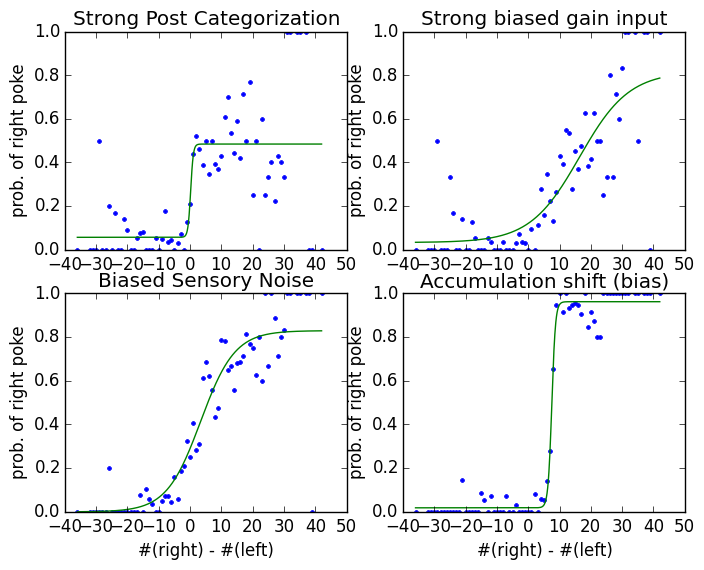

-0.0017409945983930485, bias  : 3.3845888401139486
4: lapse : 0.01689556084414601, bias  : 7.513089952125444


In [70]:
figure; 
subplot(221); plot(C1,prob_right1,linestyle="none",marker=".")
fit = curve_fit(sig4, C1, prob_right1, [0.1, 0.2, 0.5, 0.2])
x = minimum(C1):0.1:maximum(C1)
y = sig4(x,fit.param)
plot(x,y)
ylim(0,1)
# xlabel("#(right) - #(left)")
ylabel("prob. of right poke")
title("Strong Post Categorization")
println("1: lapse : ", fit.param[1], ", bias  : ", fit.param[3])

subplot(222); plot(C2,prob_right2,linestyle="none",marker=".")
fit = curve_fit(sig4, C2, prob_right2, [0.1, 0.2, 0.5, 0.2])
x = minimum(C2):0.1:maximum(C2)
y = sig4(x,fit.param)
plot(x,y)
ylim(0,1)
# xlabel("#(right) - #(left)")
ylabel("prob. of right poke")
title("Strong biased gain input")
println("2: lapse : ", fit.param[1], ", bias  : ", fit.param[3])

subplot(223); plot(C3,prob_right3,linestyle="none",marker=".")
fit = curve_fit(sig4, C3, prob_right3, [0.1, 0.2, 0.5, 0.2])
x = minimum(C3):0.1:maximum(C3)
y = sig4(x,fit.param)
plot(x,y)
ylim(0,1)
xlabel("#(right) - #(left)")
ylabel("prob. of right poke")
title("Biased Sensory Noise")
println("3: lapse : ", fit.param[1], ", bias  : ", fit.param[3])

subplot(224); plot(C4,prob_right4,linestyle="none",marker=".")
fit = curve_fit(sig4, C4, prob_right4, [0.1, 0.2, 0.5, 0.2])
x = minimum(C4):0.1:maximum(C4)
y = sig4(x,fit.param)
plot(x,y)
ylim(0,1)
xlabel("#(right) - #(left)")
ylabel("prob. of right poke")
title("Accumulation shift (bias)")
println("4: lapse : ", fit.param[1], ", bias  : ", fit.param[3])

